In [1]:
import pandas as pd 
import numpy as np 
import sys
sys.path.append('../imo/')

In [23]:
melanoma = pd.read_table('../../../maleki-coombes/data/\
                         raw/SKCM/edited/TCGA.SKCM.mutect.\
                         4b7a5729-b83e-4837-9b61-a6002dce1c0a.DR-10.0.somatic.maf')


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (87,88,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Driver Mutation 
 ### Using Mutsigcv to choose driver mutation this mutation are the first 29 mutation in mutcigcv.
### you can find the csv file of all the mutation and the score of them in result folder 
 

In [24]:
driver_genes = ["BRAF","PEA15","PPP6C","TP53","PTEN",
                "NRAS","CDKN2A","NF1","RAC1","ARID2","RB1",
                "C1QTNF9","DDX3X","AGXT2","ZFX","B2M","CTNNB1",
                "GALNTL5","COL4A3","RPL5","CYP3A5","RARRES2","TNFRSF8",
                "LCE1B","DDX4","HIST1H2AA","HNF4G","EREG","LCK"]

In [26]:
melanoma = melanoma[melanoma.Hugo_Symbol.isin(driver_genes)]

# OncoTree
#### Algorithm
Note that we primarily want to learn the structure of the tree not the conditional probabilities $\alpha(e)$s. 
    
To simplify the notation, let $p_i = P(X_i = 1)$, $p_{ij} = P(X_i = 1, X_j = 1)$, and $p_{j|i} = P(X_j = 1|X_i = 1)$. 
	We define the weight of edges between mutation $i$ and $j$ as: $w_{ij} = \log \frac{p_i}{p_i + p_j} \frac{p_{j|i}}{p_j}$.
	
The weights captures the intuition behind ``$i$ being the parent of $j$'': If $i$ is more frequent and when it happens it increases the probability of $j$ happening. 
	Authors show that the maximum branching or the graph constructed with edge weights $w_{ij}$ is exactly the tree $T$. 
	To compute the weights from the data we replace the probabilities with the frequencies: $w_{ij} = \log \frac{f_{ij}}{f_j(f_i + f_j)}$.
	
Therefore, we are after a maximum directed tree in a weighted graph. 
To filter out false positives and reduce the size of the problem, we focus on a subset of mutations, i.e., maximum-weight clique of the graph. 
Then we use the Edmond's algorithm which runs in $O(n^2)$  and finds the minimum branching of the graph with negated edge weights $-w_{ij}$. 


<img src="./img/OncoTree1.png" alt="drawing" style="width:800px;"/>


```python
class OncoTree(object):
    """
    The tree model for oncogenesis by Desper, Richard, et al.

    This implementation is based on:

        Desper, R., Jiang, F., Kallioniemi, O. P., Moch, H., Papadimitriou, C. H., & Schäffer, A. A. (1999).
        Inferring tree models for oncogenesis from comparative genome hybridization data.
        Journal of computational biology, 6(1), 37-51. URL: https://www.ncbi.nlm.nih.gov/pubmed/10223663

    Parameters
    ----------
    min_mutations : integer or None, optional (default=None)
        Minimum number of mutations to consider. The genes which has mutated below this number
        will be dropped. If ``None``, no mutation is skipped.
    """

    def __init__(self, min_mutations=None):
        self.G = None
        self.edge_list = None
        self.optimum_branching = None
        self.min_mutations = min_mutations

    def create_init_graph(self, df):
        # for each gene, find the set of patients whom this gene has mutated in them and 
        # its size of this set
        cases = pd.DataFrame(df.groupby('Hugo_Symbol')['case_id'].apply(set))
        cases = cases.append(pd.DataFrame(set(df.case_id.unique()), columns=['case_id'], index=['zero']))
        cases['count'] = cases['case_id'].apply(len)

        # drop low mutated genes if desired
        if self.min_mutations is not None:
            cases = cases[cases['count'] >= self.min_mutations]

        # for each pair of genes, find the size of the set of patients whom these two genes
        # has both mutated in them
        cases['key'] = 0
        cases['symbol'] = cases.index
        self.edge_list = cases[['case_id', 'symbol', 'key']].merge(cases[['case_id', 'symbol', 'key']],
                                                                   how='outer', on='key')
        self.edge_list['count'] = \
            self.edge_list.apply(lambda row: len(row['case_id_x'] & row['case_id_y'])
                                                       , axis=1)
        self.edge_list.drop(['case_id_x', 'case_id_y', 'key'], axis=1, inplace=True)

        # compute the number of cases
        n_cases = len(df['case_id'].unique())

        # compute the edge weights of the graph using the formula:
        # w_ij = log(p_ij) - log(p_i + p_j) - log(p_j)
        self.edge_list['weight'] = self.edge_list.apply(
            lambda row: np.log(row['count'] / n_cases) -
                        np.log(cases.loc[row['symbol_x']]['count'] / n_cases +
                               cases.loc[row['symbol_y']]['count'] / n_cases) -
                        np.log(cases.loc[row['symbol_y']]['count'] / n_cases)
            , axis=1)

        # create a networkx graph from the edgelist we just created
        self.G = nx.from_pandas_edgelist(self.edge_list, 
                                         source='symbol_x', 
                                         target='symbol_y', 
                                         edge_attr='weight',
                                         create_using=nx.DiGraph())
        return self.G

    def find_branching(self):
        """
        Find the oncogenetic graph using Edmond's branching algorithm. Needs ``create_init_graph`` 
        function to be called before using this function.

        Returns
        -------
        branching: networkx.DiGraph
            the oncogenetic tree

        """
        self.optimum_branching = nx.algorithms.tree.branchings.maximum_spanning_arborescence(self.G)
        return self.optimum_branching

    def fit(self, df):
        """
        Runs the Desper's algorithm on the provided data frame.

        Parameters
        ----------
        df: pandas.DataFrame
            The data matrix. Should have ``Hugo_Symbol`` and ``case_id`` columns.
        """
        self.create_init_graph(df)
        self.find_branching()

    def draw(self,
             figsize=(20, 15),
             with_edges=True,
             node_color= 'white',
             node_size= 10000,
             font_color='black',
             font_size = 20,
             width_ = 3,
             arrowsize_ = 30,
             edge_label_size = 20,
             edge_node_color = 'black'
             ):  # TODO move this function to utils
        """
        Draws the oncogenetic tree. Needs ``find_branching`` to be called before drawing.
        """
        # set the figure size
        plt.figure(figsize=figsize)

        # save the edge weights for later use
        edge_weights = {(u, v): round(self.optimum_branching[u][v]['weight'], 2) for u, v in
                        self.optimum_branching.edges}
        # change all edge weights of the branching to 1 to get a nice hierarchical tree in drawing
        for u, v in self.optimum_branching.edges:
            self.optimum_branching[u][v]['weight'] = 1
        pos = nx.drawing.nx_pydot.pydot_layout(self.optimum_branching, prog='dot')
        nx.draw(self.optimum_branching,
                pos,
                with_labels = True,
                node_color = node_color,
                node_size = node_size,
                font_color = font_color,
                font_size = font_size,
                width = width_,
                arrowsize = arrowsize_,
                edgecolors = edge_node_color)

        if with_edges:
            nx.draw_networkx_edge_labels(self.optimum_branching,
                                         pos,
                                         edge_labels=edge_weights,
                                         font_size = edge_label_size)

        # reset the edge weights to their original weights
        for u, v in edge_weights:
            self.optimum_branching[u][v]['weight'] = edge_weights[(u, v)]

```

In [29]:
from oncotree import OncoTree

model = OncoTree()

model.fit(melanoma)

../imo/oncotree.py:57: RuntimeWarning: divide by zero encountered in log
  cases.loc[row['symbol_y']]['count'] / n_cases) -


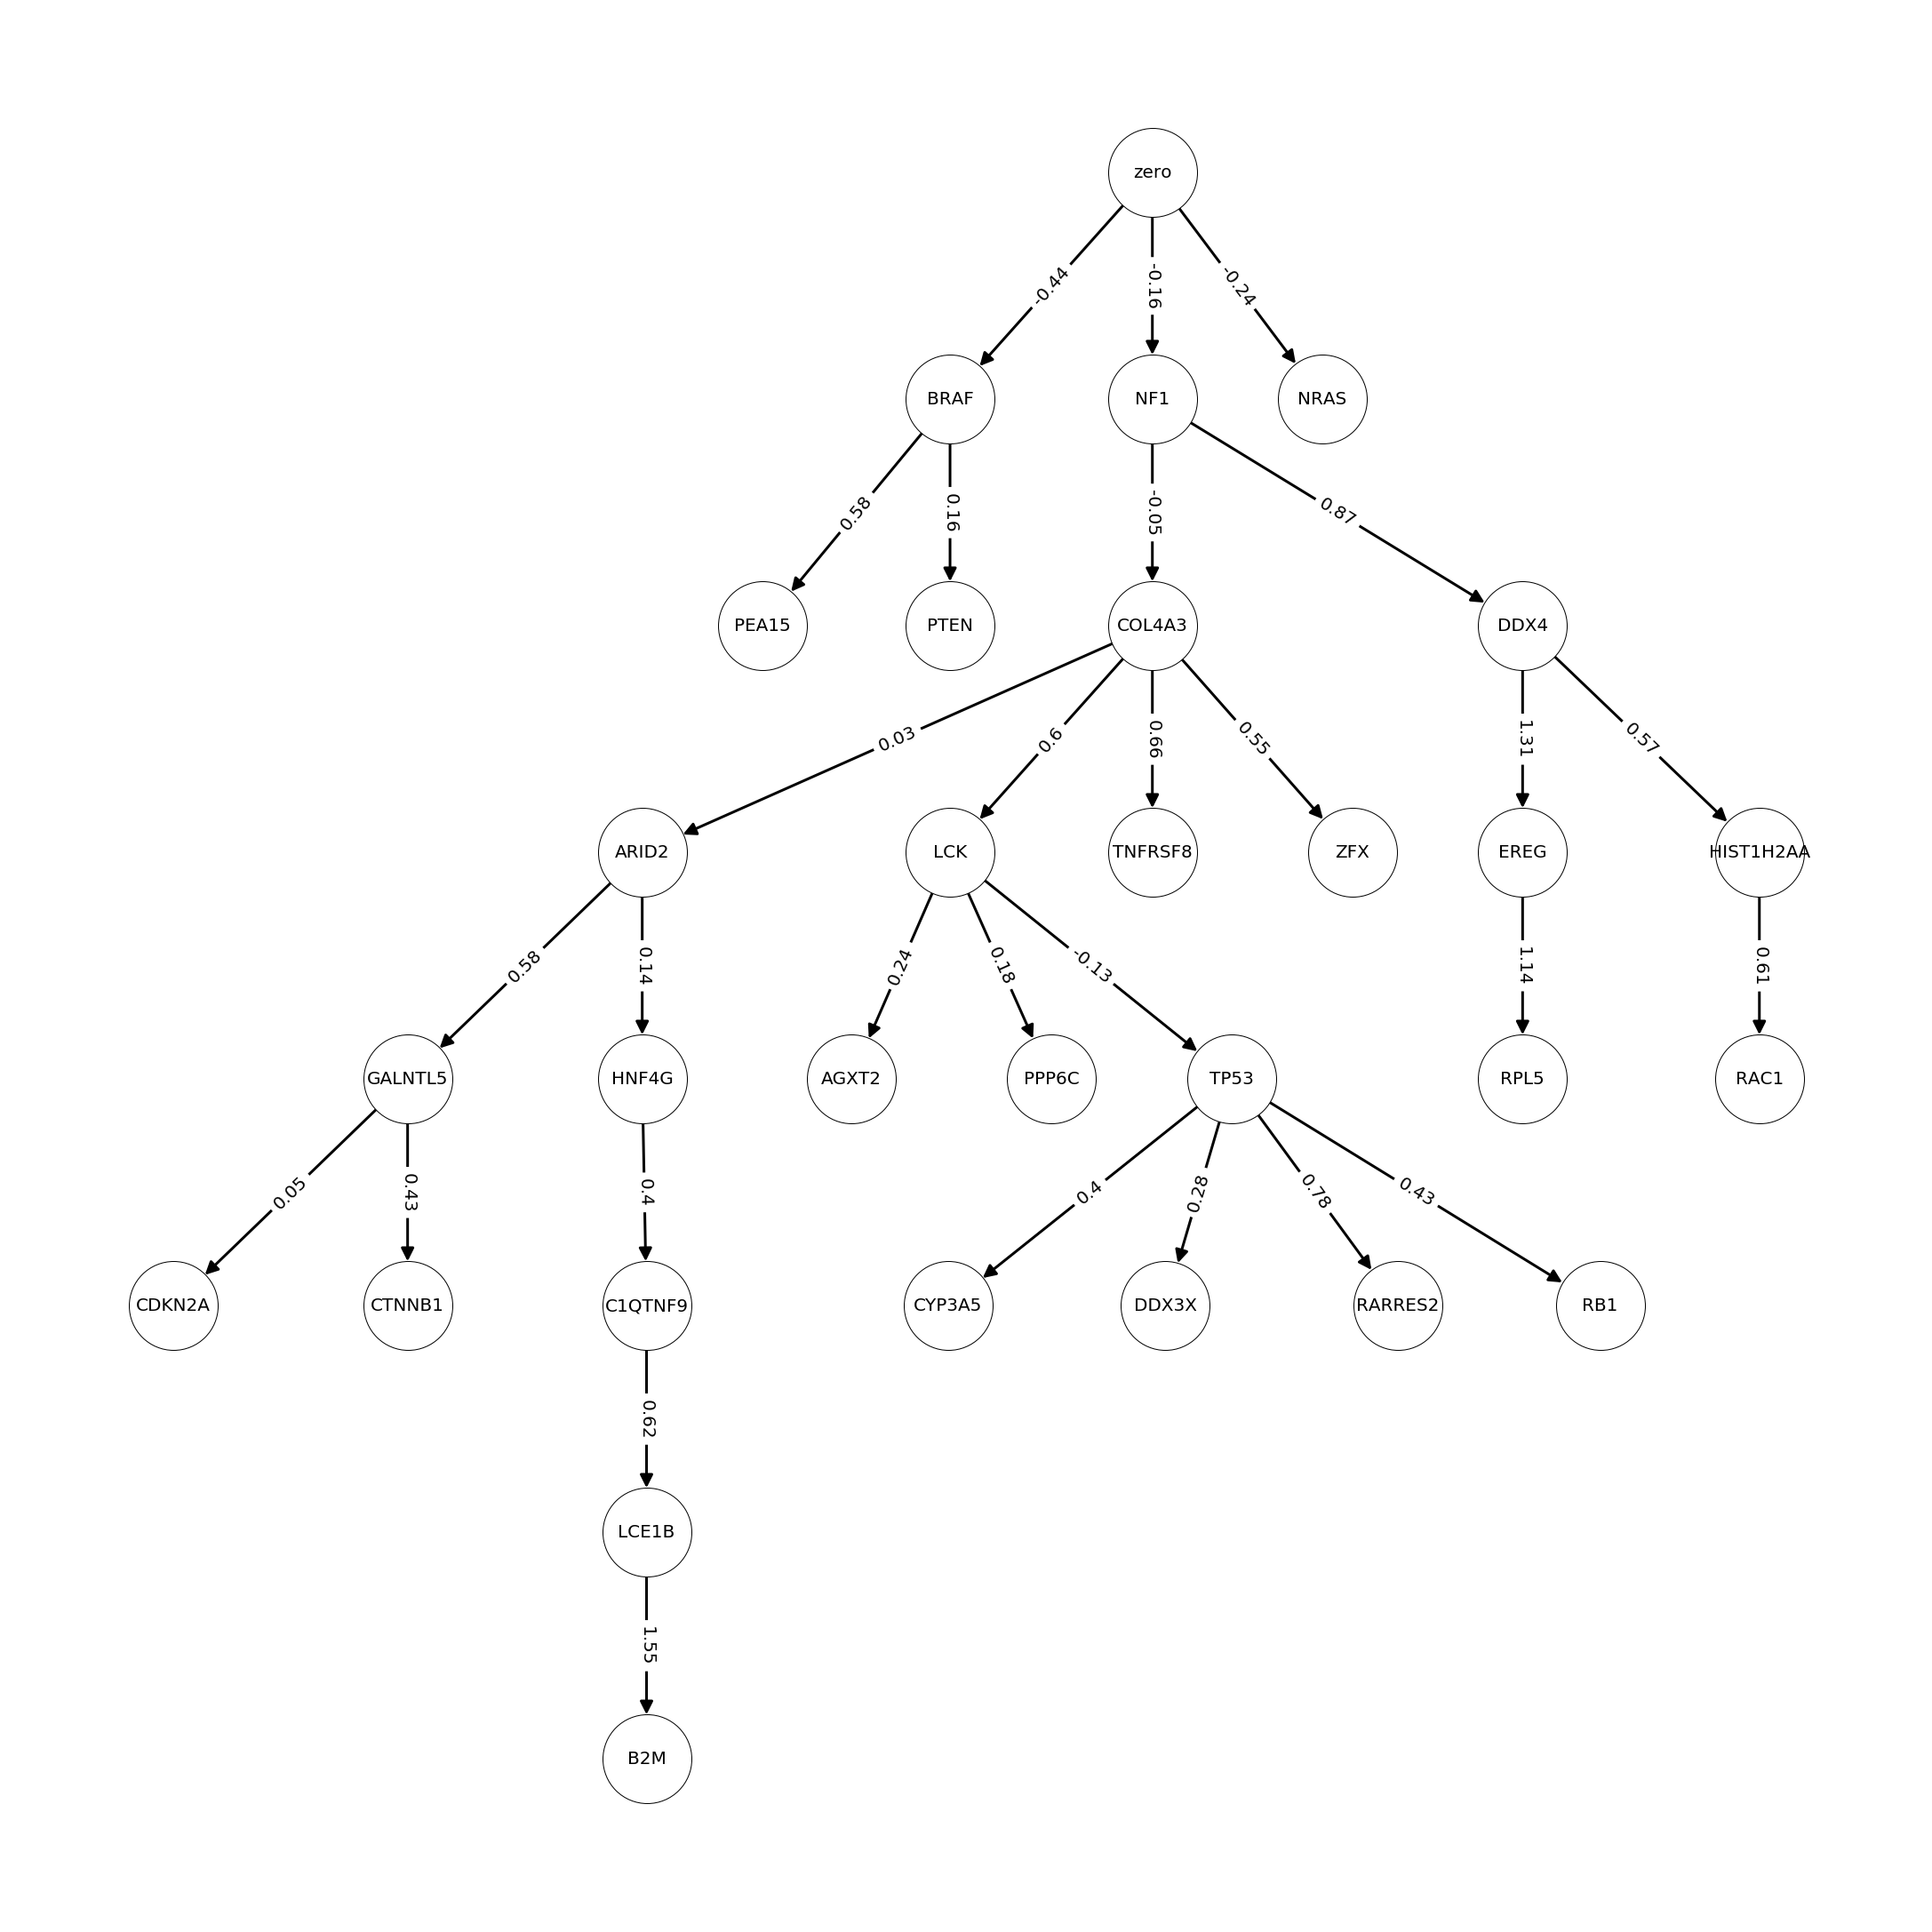

In [30]:
model.draw(figsize=(30, 30))

# OncoTree with false positive and negetive

<img src="./img/onco2.png" alt="drawing" style="width:900px;"/>


```python
class OncoTreeWithFpFn(object):
    """
    The tree model for oncogenesis by Szabo, Aniko, et al.

    This implementation is based on:

        Szabo, A., & Boucher, K. (2002). Estimating an oncogenetic treewhen false negatives
        and positivesare present. Mathematical biosciences, 176(2), 219-236.

    Parameters
    ----------
    min_mutations : integer or None, optional (default=None)
        Minimum number of mutations to consider. The genes which has mutated below this number
        will be dropped. If ``None``, no mutation is skipped.
    """

    def __init__(self, min_mutations=None):
        self.edge_list = None
        self.opontimum_branching = None
        self.min_mutations = min_mutations
        self.mutation_freq = None
        self.branching_edge = None

    def create_init_graph(self, df):
        # for each gene, find the set of patients whom this gene has mutated
        # in them and its size of this set
        cases = pd.DataFrame(df.groupby('Hugo_Symbol')['case_id'].apply(set))
        cases = cases.append(pd.DataFrame(set(df.case_id.unique()),
                                          columns=['case_id'],
                                          index=['zero']))
        cases['count'] = cases['case_id'].apply(len)

        # drop low mutated genes if desired
        if self.min_mutations is not None:
            cases = cases[cases['count'] >= self.min_mutations]

        # for each pair of genes, find the size of the set of patients whom these 
        # two genes has both mutated in them
        cases['key'] = 0
        cases['symbol'] = cases.index
        self.edge_list = cases[['case_id', 'symbol', 'key']].merge(cases[['case_id',
                                                                          'symbol',
                                                                          'key']],
                                                                   how='outer', on='key')
        self.edge_list['count'] = \
            self.edge_list.apply(lambda row: len(row['case_id_x'] & row['case_id_y'])
                                                       , axis=1)
        self.edge_list.drop(['case_id_x', 'case_id_y', 'key'], axis=1, inplace=True)

        # compute the number of cases
        n_cases = len(df['case_id'].unique())
        self.edge_list = self.edge_list[self.edge_list['symbol_x'] != self.edge_list['symbol_y']]

        # compute the edge weights of the graph using the formula:
        # w_ij = log(p_ij) - log(p_i + p_j) - log(p_j)
        self.edge_list['weight'] = self.edge_list.apply(
            lambda row: np.log(row['count'] / n_cases) -
                        np.log(cases.loc[row['symbol_x']]['count'] / n_cases +
                               cases.loc[row['symbol_y']]['count'] / n_cases) -
                        np.log(cases.loc[row['symbol_y']]['count'] / n_cases)
            , axis=1)
        # a list of mutation sorted by frequency
        self.mutation_freq = list(cases.sort_values('count')['symbol'])

    def find_branching(self):

        """

        find the minimum branching tree by finding the parent of every nodes


        :return: optimum branching
        """
        tree = list()
        all_edge = self.edge_list.copy()
        all_edge.sort_values('weight', ascending=False, inplace=True)
        for i in self.mutation_freq:
            try:
                tree.append(all_edge[all_edge.symbol_y == i].iloc[0])
                all_edge = all_edge[all_edge.symbol_x != i]
            except:
                print("Warning: there is a mutation that has no parent.")
        self.branching_edge = pd.DataFrame(tree)
        self.optimum_branching = nx.from_pandas_edgelist(self.branching_edge,
                                                         source='symbol_x', 
                                                         target='symbol_y',
                                                         edge_attr='weight',
                                                         create_using=nx.DiGraph())

        return self.optimum_branching

    def fit(self, df):
        """
        Runs algorithm on the provided data frame.

        :param df: pandas.DataFrame
            The data matrix. Should have ``Hugo_Symbol`` and ``case_id`` columns.
        """
        self.create_init_graph(df)
        self.find_branching()

    def draw(self,
             figsize=(20, 15),
             with_edges=True,
             node_color= 'white',
             node_size= 10000,
             font_color='black',
             font_size = 20,
             width_ = 3,
             arrowsize_ = 30,
             edge_label_size = 20,
             edge_node_color = 'black'
             ):  # TODO move this function to utils
        """
        Plot the graph

        :param figsize:
        :param weight: show the weight of edge
        """
        # set the figure size
        plt.figure(figsize=figsize)

        # save the edge weights for later use
        edge_weights = {(u, v): round(self.optimum_branching[u][v]['weight'], 2) for u, v in
                        self.optimum_branching.edges}
        # change all edge weights of the branching to 1 to get a nice hierarchical tree in drawing
        for u, v in self.optimum_branching.edges:
            self.optimum_branching[u][v]['weight'] = 1

        pos = nx.drawing.nx_pydot.pydot_layout(self.optimum_branching, prog='dot')
        nx.draw(self.optimum_branching,
                pos,
                with_labels=True,
                node_color=node_color,
                node_size=node_size,
                font_color=font_color,
                font_size=font_size,
                width=width_,
                arrowsize=arrowsize_,
                edgecolors=edge_node_color)

        if with_edges:
            nx.draw_networkx_edge_labels(self.optimum_branching,
                                         pos,
                                         edge_labels=edge_weights,
                                         font_size=edge_label_size)
        # reset the edge weights to their original weights
        for u, v in edge_weights:
            self.optimum_branching[u][v]['weight'] = edge_weights[(u, v)]


```


In [31]:
from oncotreewithfpfn import OncoTreeWithFpFn

model = OncoTreeWithFpFn()

model.fit(melanoma)

../imo/oncotreewithfpfn.py:58: RuntimeWarning: divide by zero encountered in log
  cases.loc[row['symbol_y']]['count'] / n_cases) -


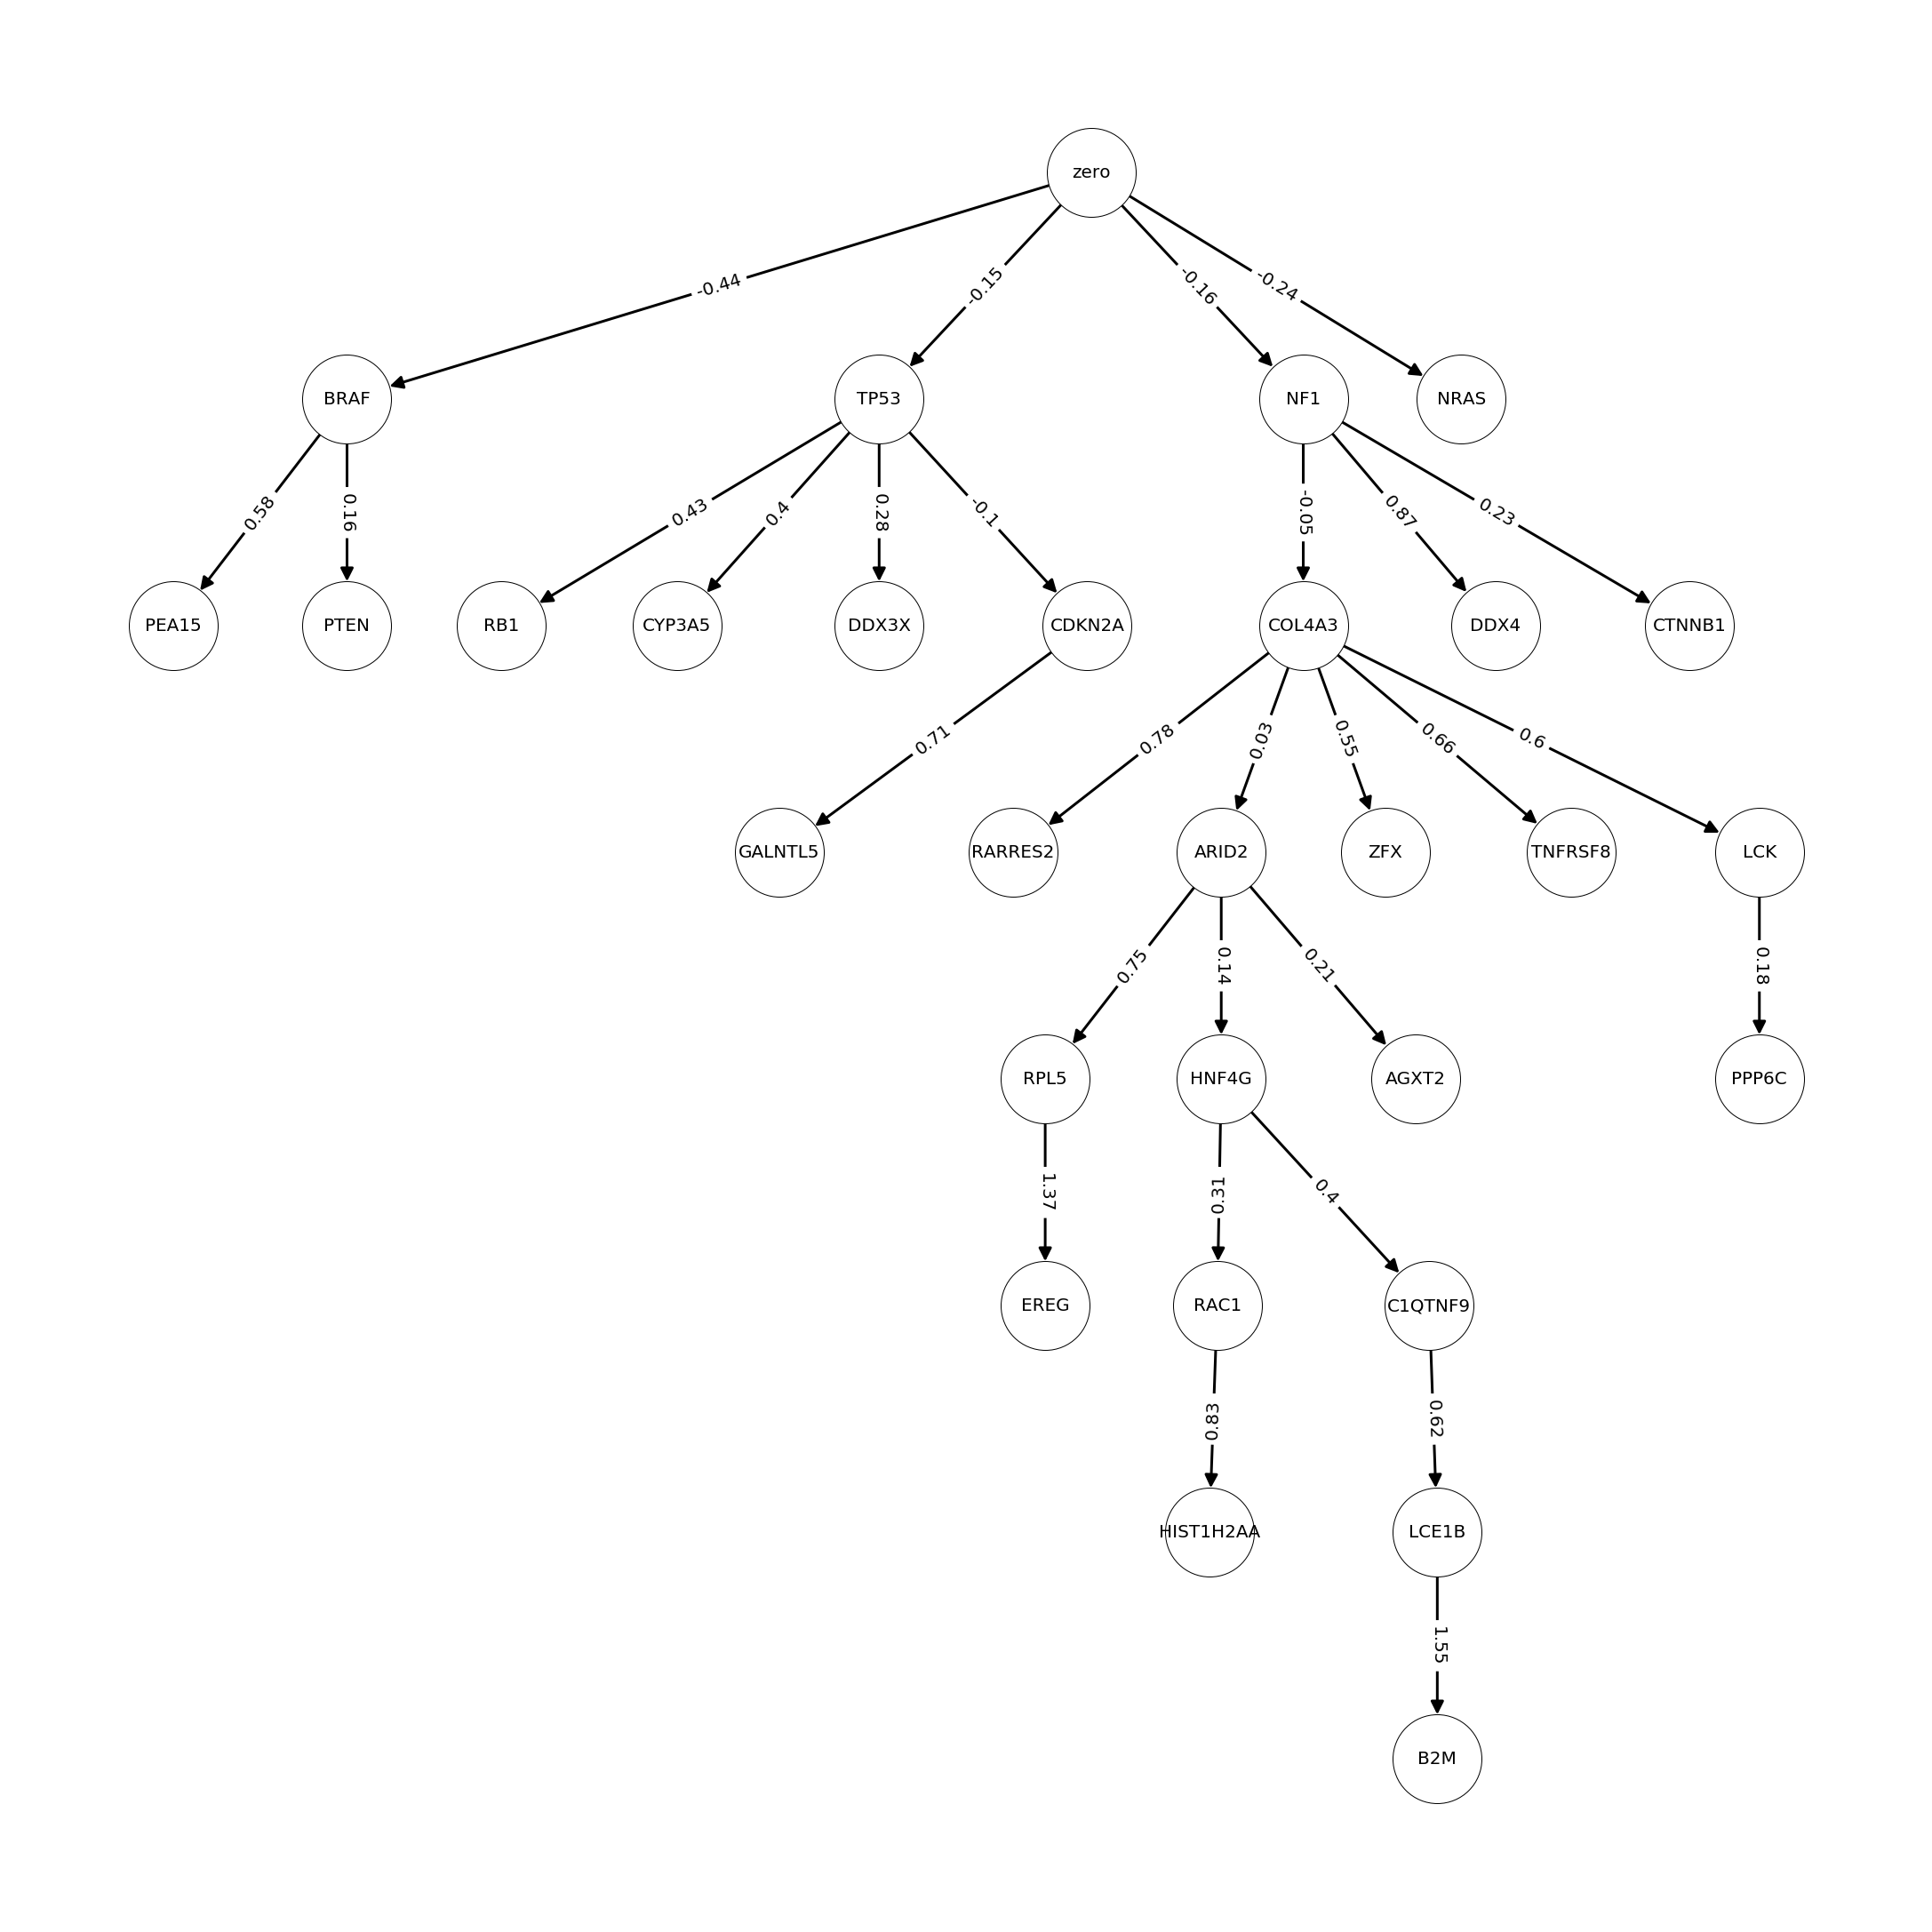

In [32]:
model.draw(figsize=(30, 30))

# CBN 

<img src="./img/cbn.png" alt="drawing" style="width:900px;"/>


```python
class CBN(object):

    def __init__(self, epsilon=None, genes=None):
        self.epsilon = epsilon
        if epsilon is None:
            self.epsilon = 0
        self.events = genes
        self.G = None

    @classmethod
    def __df_to_prob_dist(cls, df):
        return df.groupby('case_id')['Hugo_Symbol'].apply(set)

    def _reduce_events(self, u):
        pass

    def _find_structure(self, u):
        self.G = nx.DiGraph()
        for f in self.events:
            for e in self.events:
                n_errors = u.apply(lambda g: g & {e, f} == {f}).sum()
                if n_errors <= self.epsilon:
                    self.G.add_edge(e, f)
        return self.G

    def _find_probabilities(self, u):
        theta = {}
        nodes = np.copy(self.G.nodes)
        for e in nodes:
            below = u.apply(lambda g: set(self.G.predecessors(e)).issubset(g)).sum()
            if below == 0:
                self.G.remove_node(e)
            else:
                theta[e] = round(u.apply(lambda g: e in g).sum() / below, 3)
        nx.set_node_attributes(self.G, theta, 'theta')
        return theta

    def fit(self, X):
        all_genes = X['Hugo_Symbol'].unique()
        u = CBN.__df_to_prob_dist(X)

        if self.events is None:
            self.events = all_genes
        self.events = [e for e in self.events if e in all_genes]
        if 0 < self.epsilon < 1:
            self.epsilon = int(u.shape[0] * self.epsilon)

        self._reduce_events(u)
        self._find_structure(u)
        self._find_probabilities(u)

    def draw(self,
             figsize=(20, 15),
             with_node_probs=True,
             node_color='white',
             node_size=10000,
             font_color='black',
             font_size=20,
             width_=3,
             arrowsize_=30,
             edge_label_size=20,
             edge_node_color='black'):
        plt.figure(figsize=figsize)
        pos = nx.drawing.nx_pydot.pydot_layout(self.G, prog='dot')
        labels = {}
        if with_node_probs:
            for e in self.G.nodes:
                labels[e] = e + ':' + str(nx.get_node_attributes(self.G, 'theta')[e])
        nx.draw(self.G,
                pos,
                labels=labels,
                node_color=node_color,
                node_size=node_size,
                font_color=font_color,
                font_size=font_size,
                width=width_,
                arrowsize=arrowsize_,
                edgecolors=edge_node_color)

```

In [9]:
from cbn import CBN
model = CBN(epsilon= 0.01, genes=driver_genes)
model.fit(melanoma)

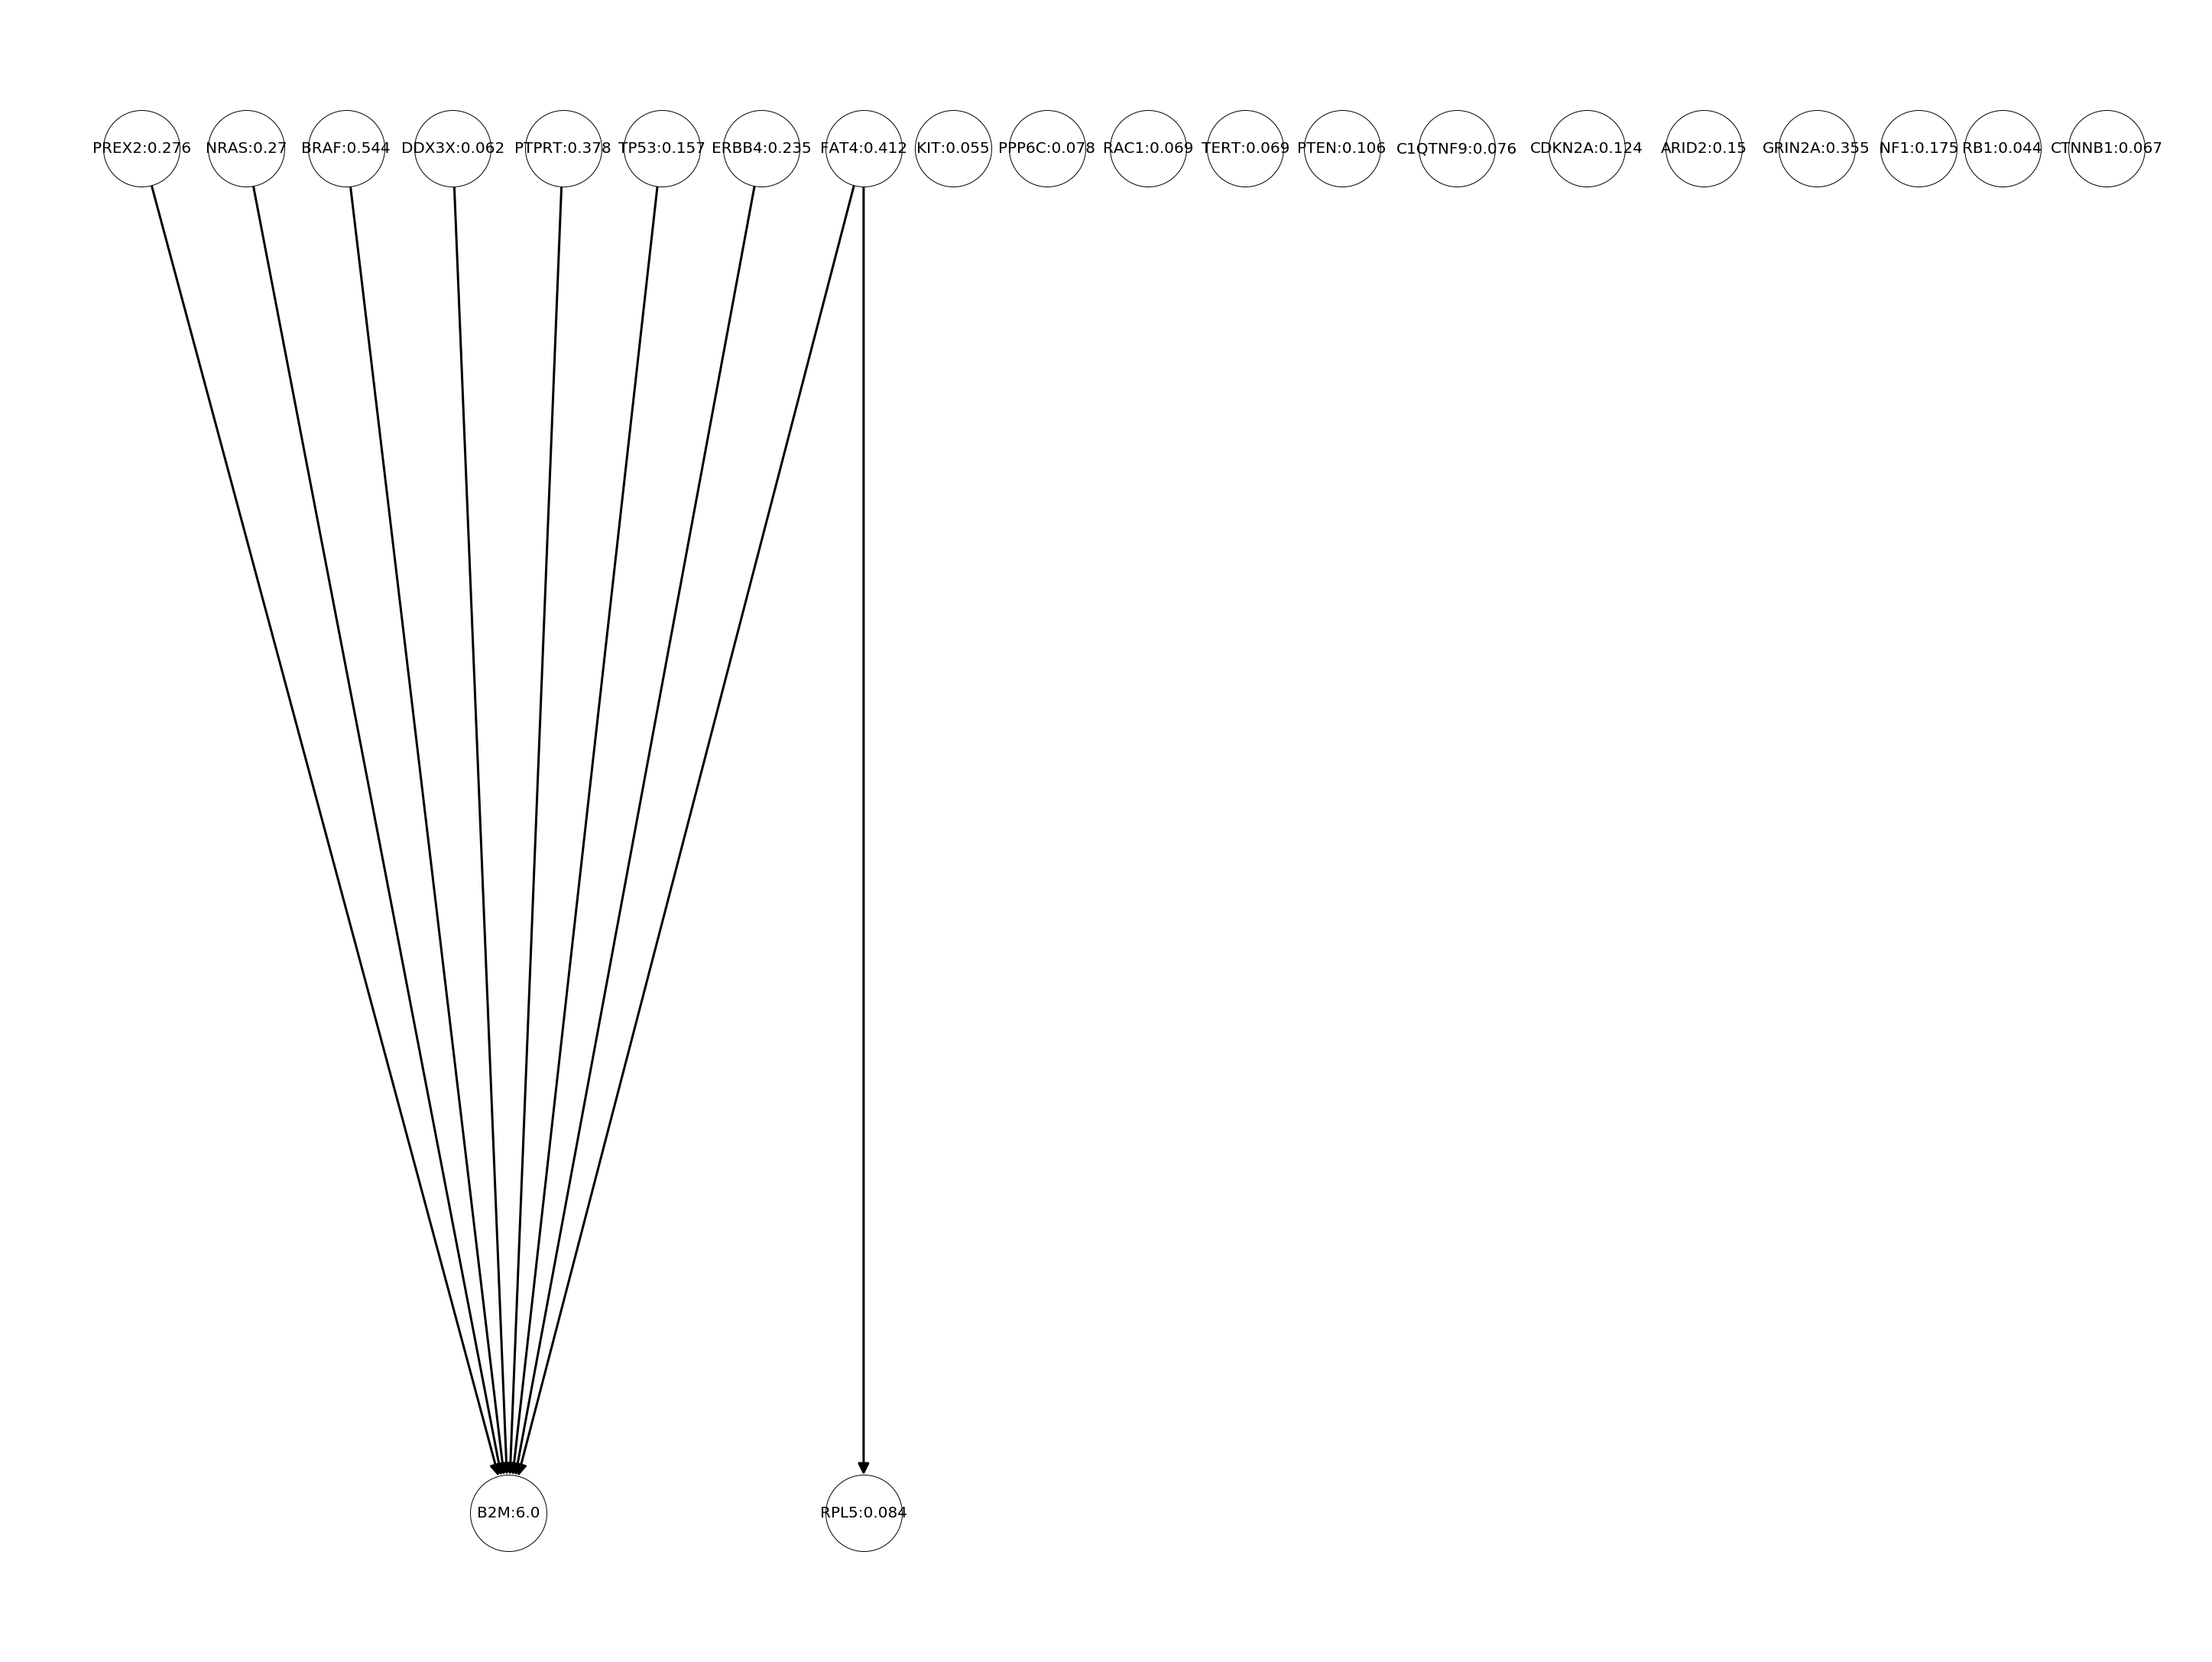

In [10]:
model.draw(font_size= 20, figsize=(40,30))

# CAPRI

<img src="./img/capri.png" alt="drawing" style="width:900px;"/>


### for this method we are using the implementation of the original papers. we add only a wrapper for python.

In [33]:
from capri import CAPRI

In [34]:
model = CAPRI()
model.fit(melanoma, driver_gens=driver_genes)
print('CAPRI')

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "Hugo_Symbol". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "Entrez_Gene_Id". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "Center". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "N

*** Importing from dataframe

Loading MAF dataframe ...
DONE

*** Mutations names: using Hugo_Symbol

*** Using full MAF: #entries 
 
1490
 


*** MAF report: 
TCGA=TRUE

Type of annotated mutations: 

 [1]
 "Missense_Mutation"     
 "Nonsense_Mutation"     
 "Splice_Site"           


 [4]
 "Frame_Shift_Del"       
 "Silent"                
 "3'UTR"                 


 [7]
 "Splice_Region"         
 "5'UTR"                 
 "Intron"                


[10]
 "Frame_Shift_Ins"       
 "In_Frame_Ins"          
 "In_Frame_Del"          


[13]
 "Translation_Start_Site"
 "5'Flank"               


*** [merge.mutation.types = T] Mutations will be merged and annotated as 'Mutation'

Number of samples:
 
424
 


[TCGA = TRUE] Number of TCGA patients:
 
424
 


Number of annotated mutations:
 
1490
 


Mutations annotated with "Valid" flag (%):
 
0
 


Number of genes (Hugo_Symbol):
 
29
 


Starting conversion from MAF to 0/1 mutation profiles (1 = mutation) :
424
 
x
 
29
 


.
.
.
.
.
.
.
.

*** Expanding hypotheses syntax as graph nodes:

*** Rendering graphics

Nodes with no incoming/outgoing edges will not be displayed.

Set automatic fontsize for edge labels: 
 
6
 


RGraphviz object prepared.

Plotting graph and adding legends.





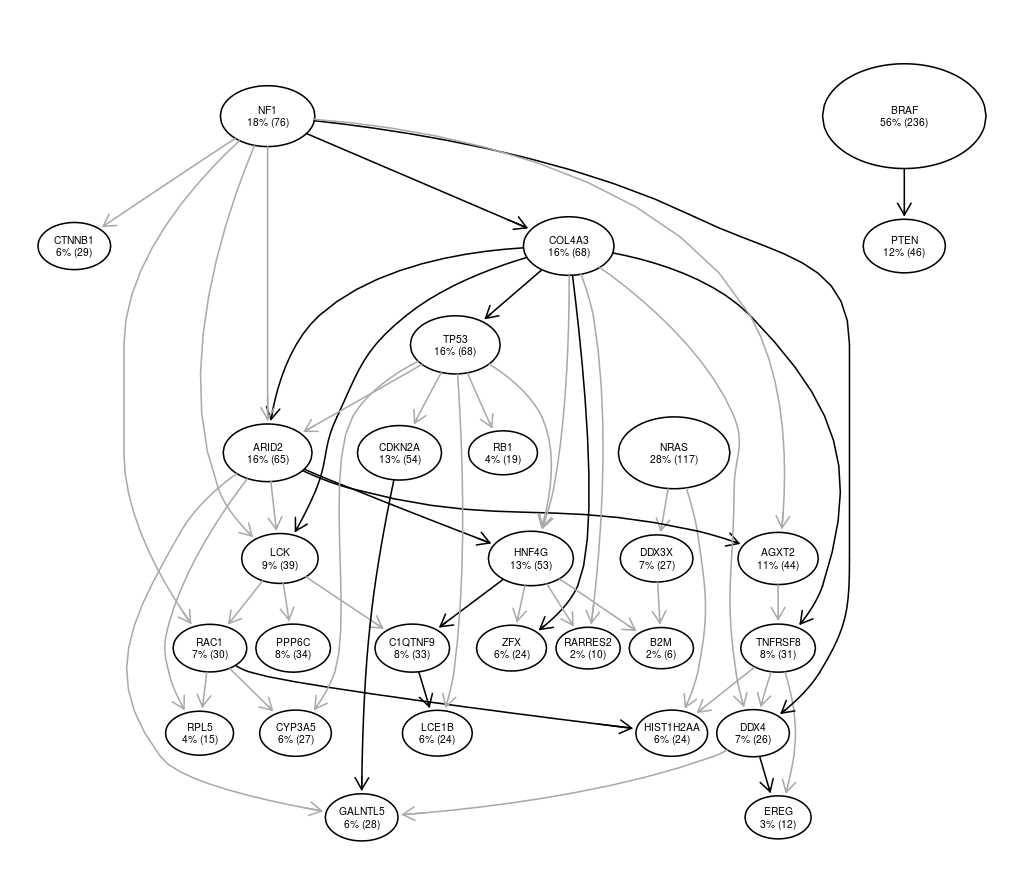

In [35]:
model.draw()

### for this method we are using the implementation of the original papers. we add only a wrapper for python.

# Caprese

In [36]:
from caprese import CAPRESE

In [37]:
model = CAPRESE()
model.fit(melanoma, driver_gens=driver_genes)
print('CAPRESE')


*** Importing from dataframe

Loading MAF dataframe ...
DONE

*** Mutations names: using Hugo_Symbol

*** Using full MAF: #entries 
 
1490
 


*** MAF report: 
TCGA=TRUE

Type of annotated mutations: 

 [1]
 "Missense_Mutation"     
 "Nonsense_Mutation"     
 "Splice_Site"           


 [4]
 "Frame_Shift_Del"       
 "Silent"                
 "3'UTR"                 


 [7]
 "Splice_Region"         
 "5'UTR"                 
 "Intron"                


[10]
 "Frame_Shift_Ins"       
 "In_Frame_Ins"          
 "In_Frame_Del"          


[13]
 "Translation_Start_Site"
 "5'Flank"               


*** [merge.mutation.types = T] Mutations will be merged and annotated as 'Mutation'

Number of samples:
 
424
 


[TCGA = TRUE] Number of TCGA patients:
 
424
 


Number of annotated mutations:
 
1490
 


Mutations annotated with "Valid" flag (%):
 
0
 


Number of genes (Hugo_Symbol):
 
29
 


Starting conversion from MAF to 0/1 mutation profiles (1 = mutation) :
424
 
x
 
29
 


.
.
.
.
.
.
.
.

*** Expanding hypotheses syntax as graph nodes:

*** Rendering graphics

Nodes with no incoming/outgoing edges will not be displayed.

Set automatic fontsize for edge labels: 
 
6
 


RGraphviz object prepared.

Plotting graph and adding legends.





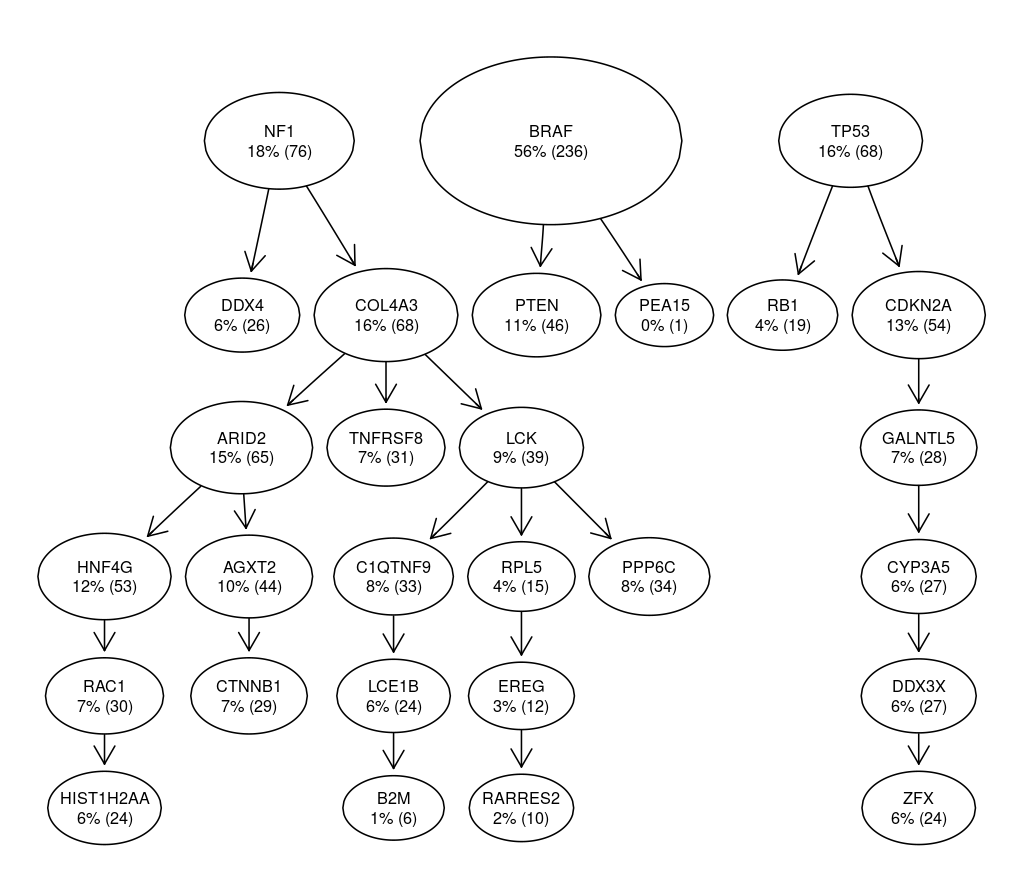

In [38]:
model.draw()

# Mixtree 

### for this method we are using the implementation of the original papers. we add only a wrapper for python.

In [39]:
from treemix import Treemix


In [40]:
model = Treemix()
model.fit(melanoma, driver_gens= driver_genes)

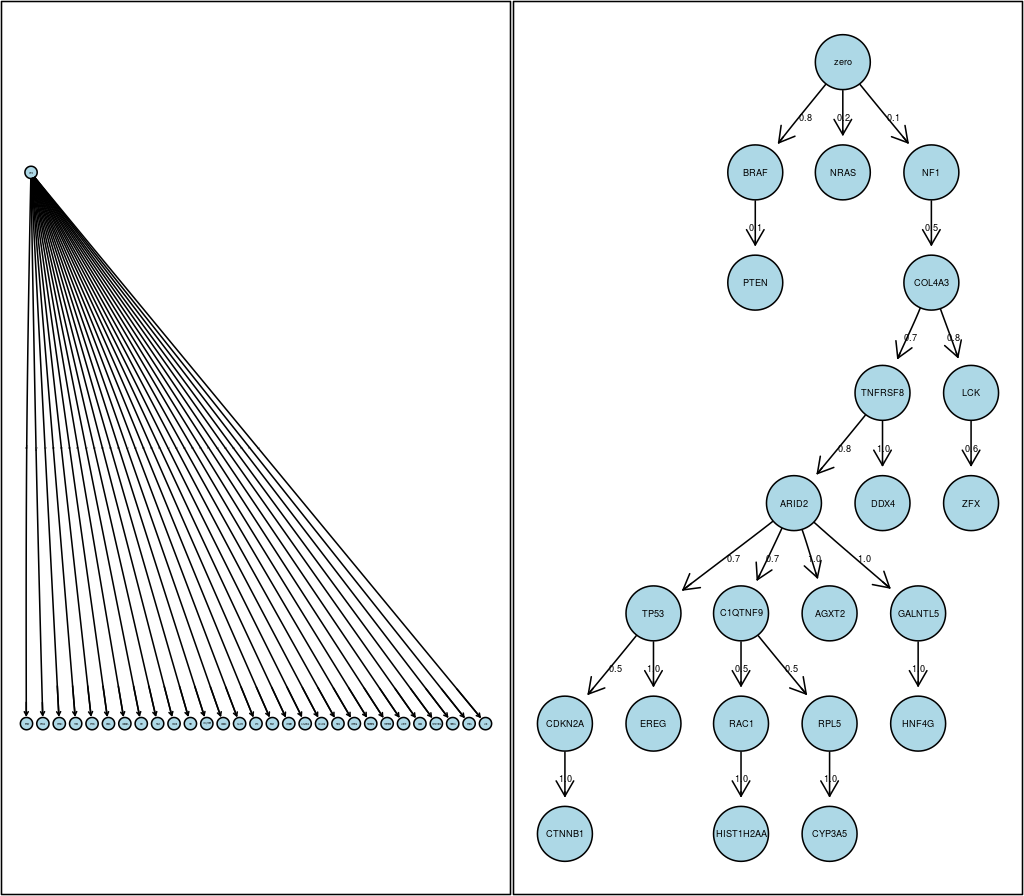

In [41]:
model.draw()